In [6]:
#from speech.process import process_frame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython

from scipy.io import wavfile
import scipy.signal.windows as windows
import scipy.signal as signal
from scipy.fftpack import fft, ifft
import math
#from transforms.dft import DFT
#from windows import *

In [7]:
fs, s = wavfile.read('../samples/arctic_b0443.wav')
s = s/np.max(s)

In [8]:
# Read input signal
IPython.display.Audio(s,rate=fs)

In [33]:
class VAD(object):

    """
    Class to apply Voice Activity Detection (VAD) algorithms.
    Methods
    --------
    decision(X)
        Detect voiced segment by estimating noise floor level.
    decision_energy(frame, thresh)
        Detect voiced segment based on energy of the signal.
    """
    
    def __init__(self, N, fs, init_frame, init_level=False, tol=0, N_fft=128, tau_up=10, tau_down=40e-3, T_up=3, T_down=1.2):

        """
        Constructor for VAD (Voice Activity Detector) class.
        Parameters
        -----------
        N : int
            Length of frame.
        fs : float or int
            Sampling frequency
        tau_up : float
            Time in seconds.
        tau_down : float
            Time in seconds.
        T_up : float
            Time in seconds.
        T_down : float
            Time in seconds.
        """
        
        self.tol = tol
        self.N = N  
        self.N_fft = N_fft
        self.T = self.N/float(fs)
        self.tau_up = tau_up
        self.tau_down= tau_down
        self.T_up = T_up
        self.T_down = T_down
        self.fs = fs
        self.eta_up = 1.2
        self.eta_down = 40e-3
        self.eta_min = 2

        self.W = windows.boxcar(math.ceil(N_fft/2))
        
        if init_level == True :
            X = fft(init_frame, N_fft)
            X = X[math.ceil(N_fft/2):]
            L = np.sum((self.W*abs(X))**2)/len(X)
            self.L_min = (self.T/self.tau_down)*L
        else :
            self.L_min = 10
        
        self.lambda_init = 1
        self.V = False
        #self.L_min = init_levels(self, init_frame)
        #self.dft = DFT(N)
        
    def decision_noise_level(self, x):

        """
        Detect voiced segment by estimating noise floor level.
        Parameters
        -----------
        X : numpy array
            RFFT of one signal with length self.N/2+1
        """
        X = fft(x, self.N_fft)
        X = X[math.ceil(self.N_fft/2):]
        
        L = np.sqrt(np.sum(self.W*abs(X))**2/len(X))
        
        # estimate noise floor
        if L > self.L_min:
            L_min = (1-self.T/self.tau_up)*self.L_min + self.T/self.tau_up*L
        else:
            L_min = (1-self.T/self.tau_down)*self.L_min + self.T/self.tau_down*L
        # voice activity decision
        if L/L_min < self.T_down:
            V = False
        elif L/L_min > self.T_up:
            V = True
        else:
            V = self.V
            
        self.L_min = L_min
        self.V = V
        
        return V
        
    def decision_energy(self, frame, thresh):

        """
        Detect voiced segment based on energy of the signal.
        Parameters
        -----------
        frame : numpy array
            One signal of length self.N
        thresh : float
            Threshold for detecting voiced segment.
        """
        tol = 1e-14
        E = np.log10(np.linalg.norm(frame)+self.tol)
        if E <= thresh:
            return False
        else:
            return True
        
    def decision_statistical(self, x, thresh) :
        X = fft(x, self.N_fft)
        X = X[math.ceil(self.N_fft/2):]
        tol=1e-14
        
        K = X.shape[0]
        gamma = abs(X)
        xhi = gamma - 1
        
        LAMBDA = np.sum(gamma - np.log10(gamma+tol) - 1)/K
        
        if LAMBDA > self.eta_min:
            self.eta_min = (1-self.T/self.eta_up)*self.eta_min + self.T/self.eta_up*LAMBDA
        else:
            self.eta_min = (1-self.T/self.eta_down)*self.eta_min + self.T/self.eta_down*LAMBDA
            
        # voice activity decision
        if LAMBDA < self.eta_down:
            V = False
        elif LAMBDA > self.eta_up:
            V = True
        else:
            V = self.V
            
        return V

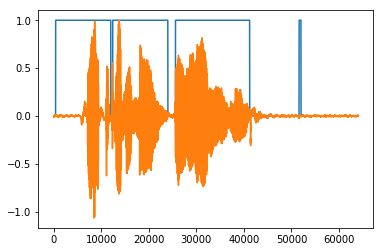

In [10]:
# Init with L
frame_length=400

start = 0
end = start+frame_length
vad = VAD(N=frame_length, fs=fs, init_frame=s[start:end], init_level=True)

results = [False]
results_plot = np.array([])
results_plot = np.append(results_plot, np.repeat(False, [frame_length]))
nframes = int(np.ceil((len(s))/(frame_length)))
for ind_frame in range(1, nframes) :
    start = ind_frame*frame_length
    end = start+frame_length
    
    V = vad.decision_noise_level(s[start:end])
    results.append(V)
    results_plot = np.append(results_plot, np.repeat(V, [frame_length]))
    
plt.plot(results_plot)
plt.plot(s)

IPython.display.Audio(s[results_plot > 0],rate=fs)

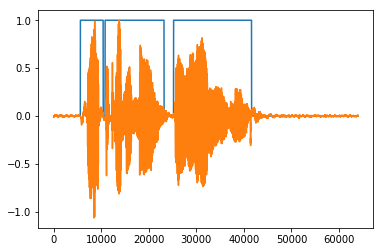

In [11]:
# Without init
frame_length=400
thresh = 0
results = []
results_plot = np.array([])
vad = VAD(N=frame_length, fs=fs, init_frame=s[start:end], N_fft=frame_length)
nframes = int(np.ceil((len(s))/(frame_length)))
for ind_frame in range(0, nframes) :
    start = ind_frame*frame_length
    end = start+frame_length
    
    V = vad.decision_noise_level(s[start:end])
    #V = vad.decision_energy(s[start:end], thresh)
    results.append(V)
    results_plot = np.append(results_plot, np.repeat(V, [frame_length]))
    
plt.plot(results_plot)
plt.plot(s)

IPython.display.Audio(s[results_plot > 0],rate=fs)

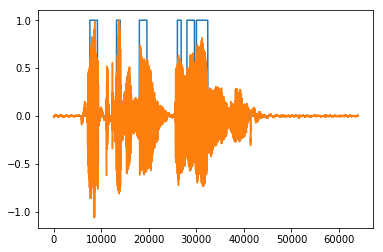

In [35]:
# Statistical
frame_length=400
thresh = 1
results = []
results_plot = np.array([])
vad = VAD(N=frame_length, fs=fs, init_frame=s[start:end], N_fft=frame_length)
nframes = int(np.ceil((len(s))/(frame_length)))
#vad.decision_statistical(s[0:frame_length], 10)
for ind_frame in range(0, nframes) :
    start = ind_frame*frame_length
    end = start+frame_length
    
    V = vad.decision_statistical(s[start:end], thresh=thresh)
    results.append(V)
    results_plot = np.append(results_plot, np.repeat(V, [frame_length]))
    
plt.plot(results_plot)
plt.plot(s)

IPython.display.Audio(s[results_plot > 0],rate=fs)

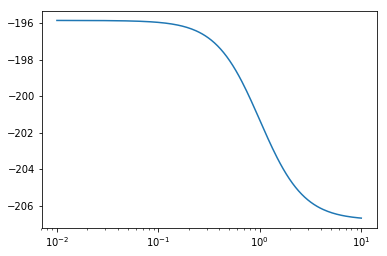

In [40]:
b, a = signal.butter(10, 1000/fs, 'low')
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))

In [41]:
# Main parameters : order of the filter, size of the frames
frame_size = 400

# Overlap : the choice of analysis and synthesis windows is as in the STFT course
# Careful that it is only consistent for a 50% overlap
overlap_ratio = 0
overlap = int(overlap_ratio*frame_size)
w_a = windows.cosine(frame_size)
w_s = windows.cosine(frame_size)

# Compute the number of frames and pad the input signal at the end with zeros
# to work only with full frames
nframes = int(np.ceil((len(s)-overlap)/(frame_size-overlap)))
nframes

160

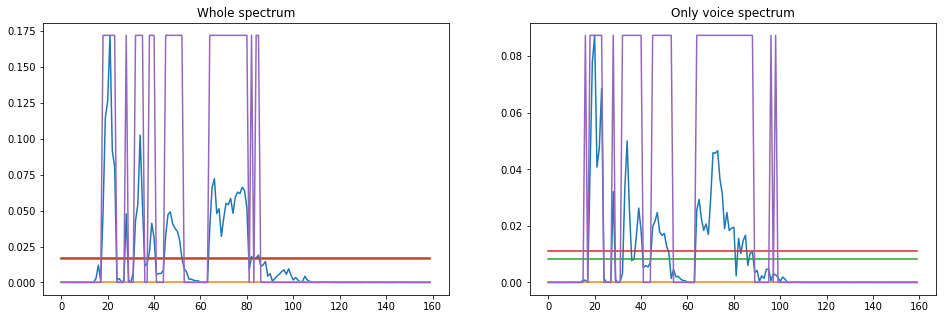

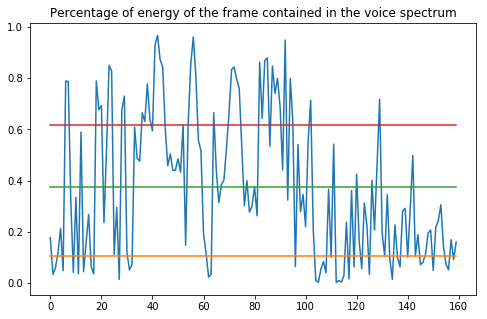

In [42]:
N_butter = 1
fc = 8000
b, a = signal.butter(N_butter, fc/fs, 'low', analog=True)
w, h = signal.freqs(b, a)
#plt.semilogx(w, 20 * np.log10(abs(h)))

results1 = []
results2 = []
for frame in range(0,nframes):
    start = frame*frame_size
    end = start+frame_size
    s2 = s[start:end]
    s2 = signal.filtfilt(b, a, s2, axis=-1)
    
    N = 128
    S = np.fft.fftshift(np.fft.fft(s2, n=N))
    S = S[int(N/2):]
    #Y = Y[1:4]
    NRJ1 = np.sum(np.abs(S)**2/N)
    NRJ2 = np.sum(np.abs(S[1:4])**2/N)
    #if NRJ >= E_min :
    #    results.append(1)
    #else :
    #    results.append(0)
    results1.append(NRJ1)
    results2.append(NRJ2)


"""ind = np.array([ind for ind, values in enumerate(results) if values == 1])
speech_init = [ind[0]]
speech_end = []
for i, indice in enumerate(ind) :
    if i < len(ind) -1 :
        if indice + 1 != ind[i+1] :
            speech_end.append(indice)
            speech_init.append(ind[i+1])
    else :
        speech_end.append(indice)
print(np.array(speech_init)*frame_size/(2*fs))
print(np.array(speech_end)*frame_size/(2*fs))"""

fig, ax = plt.subplots(1, 2, figsize=[16, 5])

"""fig = plt.figure(figsize=[16, 12])
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(results1)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(results2)

ax3 = fig.add_subplot(gs[1, 0:])
ax3.plot(np.array(results2)/np.array(results1))

gs.update(wspace=0.5, hspace=0.5)"""

# Plot the NRJ of each frame
ax[0].plot(results1)
ax[0].plot(np.percentile(results1, 25)*np.ones(len(results1))) # 1st quartile
ax[0].plot(np.mean(results1)*np.ones(len(results1)))           # median
ax[0].plot(np.percentile(results1, 75)*np.ones(len(results1))) # 3rd quartile
#ax[0].plot((results1 > np.mean(results1))*max(results1))
threshold = np.mean(results1)#np.percentile(results1, 50)
ax[0].plot((results1 > threshold)*max(results1))
ax[0].set_title('Whole spectrum')

ax[1].plot(results2)
ax[1].plot(np.percentile(results2, 25)*np.ones(len(results2))) # 1st quartile
ax[1].plot(np.mean(results2)*np.ones(len(results2)))           # median
ax[1].plot(np.percentile(results2, 75)*np.ones(len(results2))) # 3rd quartile
#ax[1].plot((results2 > np.mean(results2))*max(results2))
threshold = np.mean(results2)#np.percentile(results2, 50)
ax[1].plot((results1 > threshold)*max(results2))
ax[1].set_title('Only voice spectrum')

plt.show()

# Plot percentage of the NRJ contained in the voice spectrum
percentage = np.array(results2)/np.array(results1)
fig, ax = plt.subplots(1, 1, figsize=[8, 5])
ax.plot(percentage)
ax.plot(np.percentile(percentage, 25)*np.ones(len(percentage))) # 1st quartile
ax.plot(np.mean(percentage)*np.ones(len(percentage)))           # median
ax.plot(np.percentile(percentage, 75)*np.ones(len(percentage))) # 3rd quartile
ax.set_title('Percentage of energy of the frame contained in the voice spectrum')

plt.show()

Full-band energy = 0.012110601445312497
Subband energy = 0.0007434702092957806


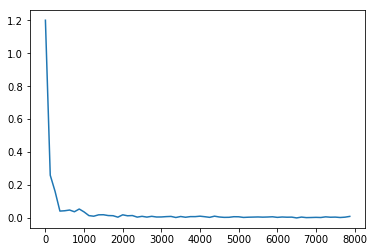

In [43]:
frame = 2
start = frame*frame_size
end = start+frame_size

N = 128
S = np.fft.fftshift(np.fft.fft(s[start:end], n=N))
S = S[int(N/2):]

freq = np.fft.fftshift(np.fft.fftfreq(N))*fs
freq = freq[int(N/2):]
plt.plot(freq, np.abs(S))

fullband_nrj = np.sum(np.abs(S)**2/N)
subband_nrj = np.sum(np.abs(S[1:4])**2/N)
print('Full-band energy = {}'.format(fullband_nrj))
print('Subband energy = {}'.format(subband_nrj))

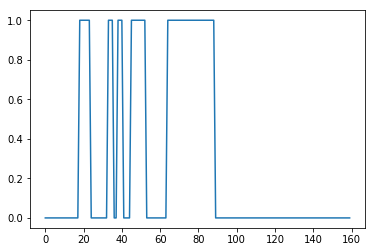

In [44]:
temp_results = results2
threshold = np.mean(temp_results)#np.percentile(temp_results, 25)
list_results = ((temp_results > threshold)*1)
final_decision = 0#list_results[0]
for ind, vad_res in enumerate(list_results[1:-1]) :
    vad_prev = list_results[ind]
    vad_next = list_results[ind+2]
    smoothed_res = np.median([vad_prev, vad_res, vad_next])
    final_decision = np.append(final_decision, smoothed_res)
    #print('ind {} : Previous = {}, Current = {}, Next = {}, Smoothed = {}'.format(ind+1, vad_prev, vad_res, vad_next, smoothed_res))

final_decision = np.append(final_decision, list_results[-1])
plt.plot(final_decision)

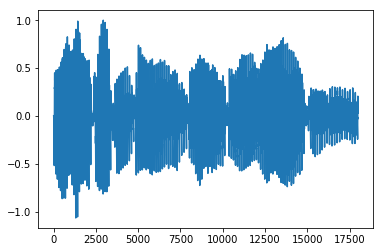

In [90]:
ind = np.array([ind for ind, values in enumerate(final_decision) if values == 1])
vad_signal = []
for i in ind :
    start = i*frame_size
    end = start+frame_size
    vad_signal = np.append(vad_signal, s[start:end])
plt.plot(vad_signal)

In [91]:
IPython.display.Audio(vad_signal,rate=fs)

[4.57988150e-11 4.57988150e-10 2.06094667e-09 5.49585780e-09
 9.61775115e-09 1.15413014e-08 9.61775115e-09 5.49585780e-09
 2.06094667e-09 4.57988150e-10 4.57988150e-11]


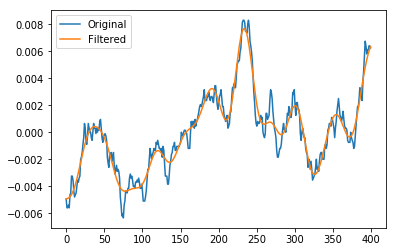

In [76]:

s2 = s[start:end]
plt.plot(s2, label='Original')
#print(s2)
s2 = signal.filtfilt(b, a, s2, axis=-1)
plt.plot(s2, label='Filtered')
plt.legend()
print(b)